# Previsione dell'affidabilità creditizia per il rilascio della carta di credito

Sei stato assunto dalla Pro National Bank come data scientist, e il tuo primo incarico consiste nel realizzare un modello in grado di stimare l'affidabilità creditizia dei clienti, al fine di aiutare il team dedicato a comprendere se accettare o meno la richiesta per il rilascio della carta di credito.

## Project Aim
The goal of this project is to build a ML model to estimate the credit affordability of clients.

## Library import

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay,confusion_matrix,classification_report,f1_score,log_loss,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [227]:
RANDOM_SEED = 0

## Helper Functions

In [228]:
def plot_cm(y_true,y_pred,title="Confusion Matrix",show_precision_recall = False):
    """
    Plot a confusion matrix heatmap with optional precision and recall metrics.
    
    Parameters:
    y_true : array-like
        True binary labels.
    y_pred : array-like
        Predicted binary labels.
    title : str, default="Confusion Matrix"
        Title for the confusion matrix plot.
    show_precision_recall : bool, default=False
        If True, displays precision and recall values below the heatmap.
    
    Returns: None
    """
    cm = confusion_matrix(y_true,y_pred)
    df_cm = pd.DataFrame(cm,
                        index = ["Negative","Positive"],
                        columns = ["Predicted Negative","Predicted Positive"])
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm,annot=True,fmt="d",cmap="crest")
    plt.title(title)
    if show_precision_recall:
        plt.text(0,-0.1,f"Precision: {cm[1][1]/(cm[1][1]+cm[0][1]):.2f}")
        plt.text(1,-0.1,f"Recall: {cm[1][1]/(cm[1][1]+cm[1][0]):.2f}")
    

def report_result(model, X, y, graph_title="Train set"):
    """
    Prints classification report, accuracy score, and displays ROC curve and confusion matrix plots.
    
    Parameters:
    model : sklearn estimator
        Trained machine learning model with predict() and predict_proba() methods.
    X : array-like or pandas.DataFrame
        Feature matrix for evaluation.
    y : array-like
        True binary labels.
    graph_title : str, default="Train set"
        Title prefix for all generated plots and printed output.
    
    Return: None
    """
    # Predictions
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    
    # Accuracy
    acc = accuracy_score(y, y_pred)
    
    # Print results
    print(f"{graph_title} Evaluation")
    print(f"Accuracy: {acc:.4f}\n")
    print(classification_report(y, y_pred))
    
    # ROC curve
    RocCurveDisplay.from_estimator(model, X, y)
    plt.title("ROC Curve " + graph_title)
    plt.show()
    
    # Confusion matrix
    plot_cm(y, y_pred, title=f"{graph_title} Confusion Matrix", show_precision_recall=True)


def barplot_target_feature(df,target_name,feature_name):
    """
    Create a 100% stacked bar plot showing target distribution across feature categories.
    
    Parameters:
    df : pandas.DataFrame
        DataFrame with feature categories as index and target percentages as columns (pd.crosstab).
        Values should already be in percentage format.
    target_name : str
        Name of the target variable for y-axis label.
    feature_name : str
        Name of the feature variable for x-axis label and plot title.
    
    Returns: None
        Displays the stacked bar plot.
    """
    plt.figure()
    df.plot(kind="bar",stacked=True,figsize=(8,6),color=["tomato","teal"])
    plt.title(f"Response based on {feature_name} distribution")
    plt.xlabel(feature_name)
    plt.ylabel(target_name + " %")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Data Preprocessing and EDA

In [229]:
# We start by importing the dataset and visualizing the main characteristics
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
data = pd.read_csv(url)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLAG_EMAIL       

In [230]:
data[data["OCCUPATION_TYPE"].isna()]
print("NAME_INCOME_TYPE values:")
print(data['NAME_INCOME_TYPE'].value_counts())
print("\n" + "-"*30)
print("\nOCCUPATION_TYPE values:")
print(data['OCCUPATION_TYPE'].value_counts())
print(f"\nMissing Values in OCCUPATION_TYPE: {data['OCCUPATION_TYPE'].isna().sum()} ({data['OCCUPATION_TYPE'].isna().sum()/len(data)*100:.1f}%)")
# We further explore the column OCCUPATION_TYPE that has around 30% of missing values, but has more detailed information about client's occupation than
# the column NAME_INCOME_TYPE

NAME_INCOME_TYPE values:
NAME_INCOME_TYPE
Working                 174366
Commercial associate     78090
Pensioner                57841
State servant            28113
Student                     17
Name: count, dtype: int64

------------------------------

OCCUPATION_TYPE values:
OCCUPATION_TYPE
Laborers                 60146
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64

Missing Values in OCCUPATION_TYPE: 103342 (30.5%)


In [231]:
# When OCCUPATION_TYPE is missing, what is the NAME_INCOME_TYPE
occupation_missing = data[data['OCCUPATION_TYPE'].isna()]
print("When OCCUPATION_TYPE is missing:")
print(occupation_missing['NAME_INCOME_TYPE'].value_counts())
print("\nPercentages:")
print(occupation_missing['NAME_INCOME_TYPE'].value_counts(normalize=True) * 100)

When OCCUPATION_TYPE is missing:
NAME_INCOME_TYPE
Pensioner               57841
Working                 27784
Commercial associate    12927
State servant            4785
Student                     5
Name: count, dtype: int64

Percentages:
NAME_INCOME_TYPE
Pensioner               55.970467
Working                 26.885487
Commercial associate    12.508951
State servant            4.630257
Student                  0.004838
Name: proportion, dtype: float64


Most missing occupation values belong to Pensioners (56%), this makes sense since pensioners don’t have a current occupation.
The remaining missing ones are mixed. I will handle this by assigning "Pensioner" to pensioner and "Unknown" for the others.

In [232]:
data.loc[(data["OCCUPATION_TYPE"].isna()) & (data["NAME_INCOME_TYPE"] == "Pensioner"),"OCCUPATION_TYPE"] = "Pensioner"
data["OCCUPATION_TYPE"] = data["OCCUPATION_TYPE"].fillna("Unknown")

In [233]:
#First check for missing values
data.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     1
NAME_HOUSING_TYPE      1
DAYS_BIRTH             1
DAYS_EMPLOYED          1
FLAG_MOBIL             1
FLAG_WORK_PHONE        1
FLAG_PHONE             1
FLAG_EMAIL             1
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        1
TARGET                 0
dtype: int64

From a first exploratory data analysis, the dataset consists of 338.427 records and 19 columns. We will drop the ID column since it does not give any useful information for our model.

In [234]:
#We want to show records with missing values
data[data.isna().any(axis=1)]
# Only one roww has different missing values, so we can remove it

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
338426,6392180,F,N,N,0,68765.48,Working,Secondary / se,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,0


In [235]:
data = data.dropna()
data.isna().sum()
# Now we are sure that the data has no missing values, we can prooced analyzing other categorical features and the target

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
TARGET                 0
dtype: int64

In [236]:
data = data.drop(["ID"],axis=1)

Before moving on and the process the dataset further, it is helpful to show the correlation matrix beetwen the numerical features and the target.

In [237]:
# List numerical features for creation of the correlation matrix
numerical_features = list(data.select_dtypes(include=[np.number]).drop(columns=["TARGET"],axis=1))
print(f"Numerical features count: {len(numerical_features)}")
numerical_features

Numerical features count: 9


['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS']

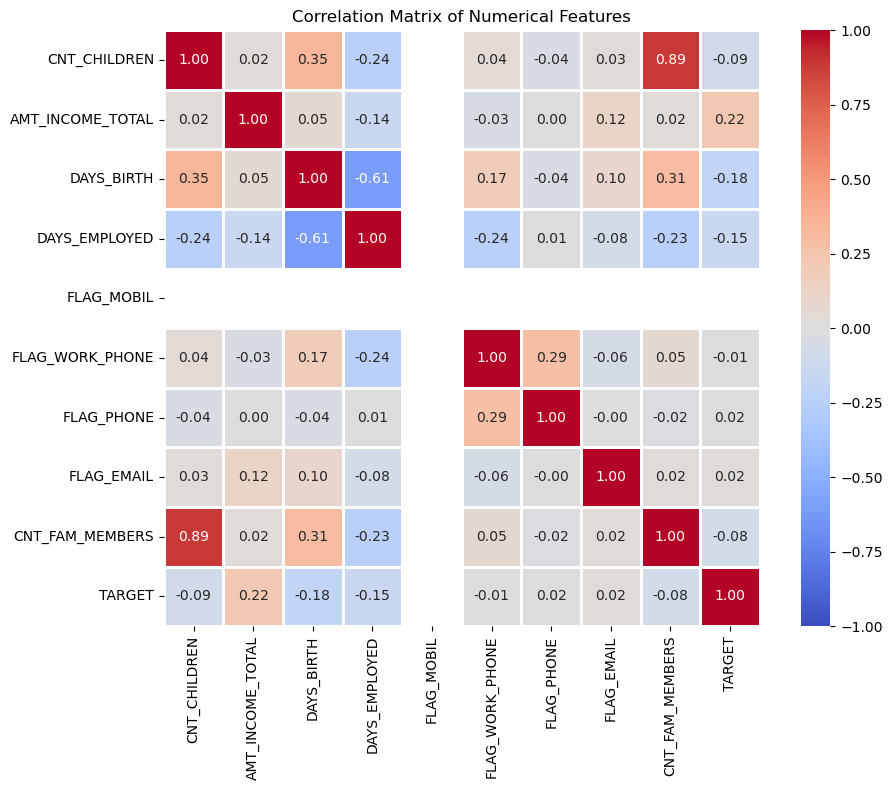


Correlations with TARGET:
TARGET              1.000000
AMT_INCOME_TOTAL    0.224318
FLAG_EMAIL          0.021330
FLAG_PHONE          0.015558
FLAG_WORK_PHONE    -0.012826
CNT_FAM_MEMBERS    -0.078138
CNT_CHILDREN       -0.091519
DAYS_EMPLOYED      -0.145328
DAYS_BIRTH         -0.184023
FLAG_MOBIL               NaN
Name: TARGET, dtype: float64


In [238]:
plt.figure(figsize=(10, 8))
correlation_matrix = data[numerical_features + ['TARGET']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

print("\nCorrelations with TARGET:")
print(correlation_matrix['TARGET'].sort_values(ascending=False))


In [239]:
data["FLAG_MOBIL"].value_counts()

FLAG_MOBIL
1.0    338426
Name: count, dtype: int64

Results from the correlation matrix: 

- DAYS_BIRTH and DAYS_EMPLOYED show moderate negative relationship with the target.
- Income has a positive correlation, while family size and number of children correlate slightly negatively.
- Phone/email contact flags (FLAG_EMAIL, FLAG_PHONE, etc) show almost no correlation, and FLAG_MOBIL has no variance (constant values), resulting in blank values.

Since the contacts features provide no predictive signal, they will be removed.

In [240]:
data = data.drop(["FLAG_WORK_PHONE","FLAG_PHONE","FLAG_EMAIL","FLAG_MOBIL"],axis=1)
data.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,TARGET
0,M,Y,Y,0,424380.57,Working,Higher education,Civil marriage,Rented apartment,-11778.0,-4438.0,Unknown,2.0,0
1,M,Y,Y,0,421593.52,Working,Higher education,Civil marriage,Rented apartment,-11777.0,-4459.0,Unknown,2.0,0
2,M,Y,Y,0,110958.51,Working,Secondary / secondary special,Married,House / apartment,-21471.0,-1144.0,Security staff,2.0,0
3,F,N,Y,0,267497.96,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18489.0,-3122.0,Sales staff,1.0,1
4,F,N,Y,0,263419.09,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19093.0,-3070.0,Sales staff,1.0,1


In [241]:
#list categorical features
categorical_features = list(data.select_dtypes(include=["object"]))
print(f"Categorical features count: {len(categorical_features)}")
categorical_features

Categorical features count: 8


['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

The dataset has 8 categorical features:
- Code_gender is a binary categorical feature and will be encoded as a dummy variable
- Flag_own_car,Flag_own_realty are boolean features and will be encoded with one hot encoding
- NAME_EDUCATION_TYPE is an ordinal categorical variable and we will map it with this order: Lower secondary, Secondary/Secondary Special, Incomplete Higher, Higher education, Academic degree
- OCCUPATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE are categorical features and will be encoded with one hot encoding.

Not trustable clients(0): 308704, 91.2% of total clients
Trustable clients(1): 29722, 8.8% of total clients


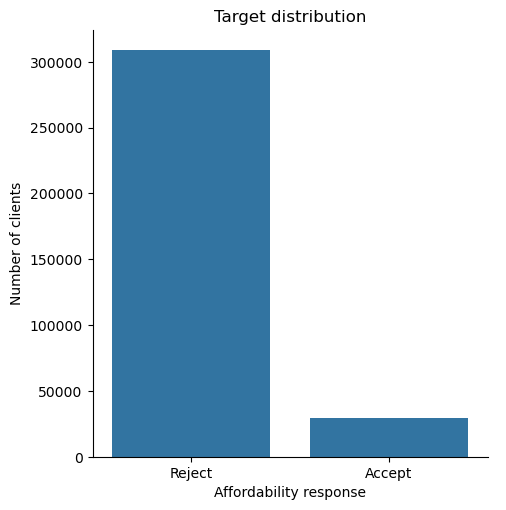

In [242]:
## Target analysis
response_frequency = data["TARGET"].value_counts()
response_percentage = data["TARGET"].value_counts(normalize=True) * 100

print(f"Not trustable clients(0): {response_frequency[0]}, {response_percentage[0]:.1f}% of total clients")
print(f"Trustable clients(1): {response_frequency[1]}, {response_percentage[1]:.1f}% of total clients")
graph = sns.catplot(data=data,x="TARGET",kind="count")
graph.set_xticklabels(["Reject","Accept"])
graph.set_axis_labels("Affordability response","Number of clients")
plt.title("Target distribution")
plt.show()

The dataset is clearly unbalanced towards "Not trustable clients". Undersampling will be perfomed to balance the classes and to reduce computational costs of model training.

### Analysis of categorical data

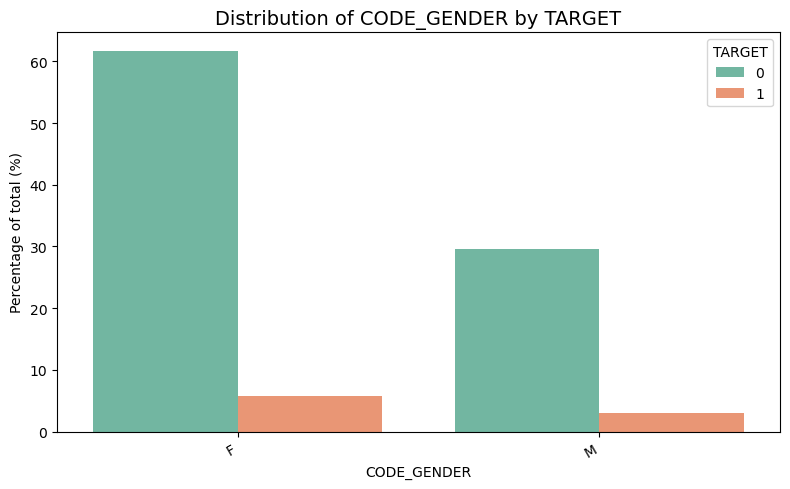

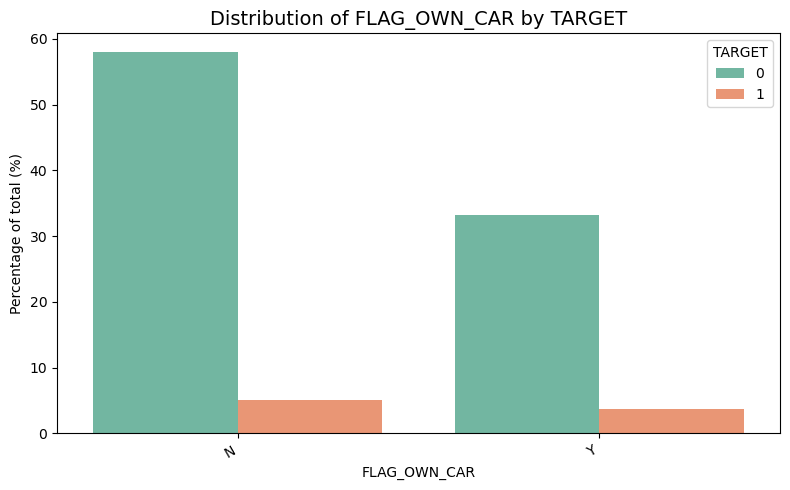

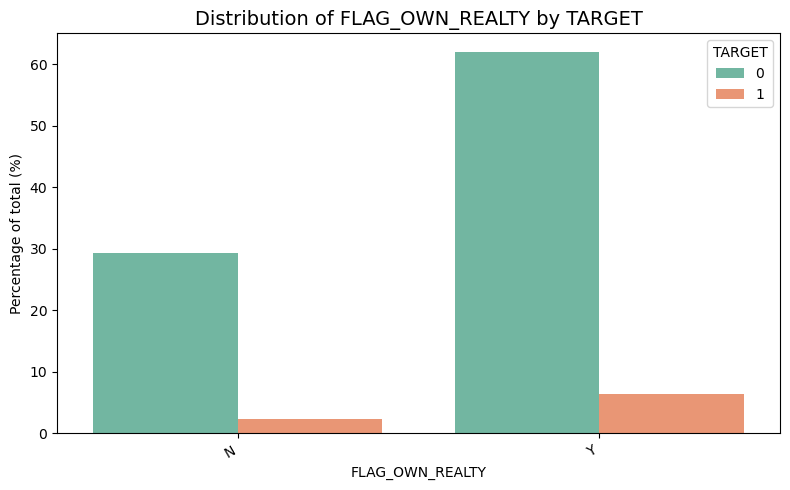

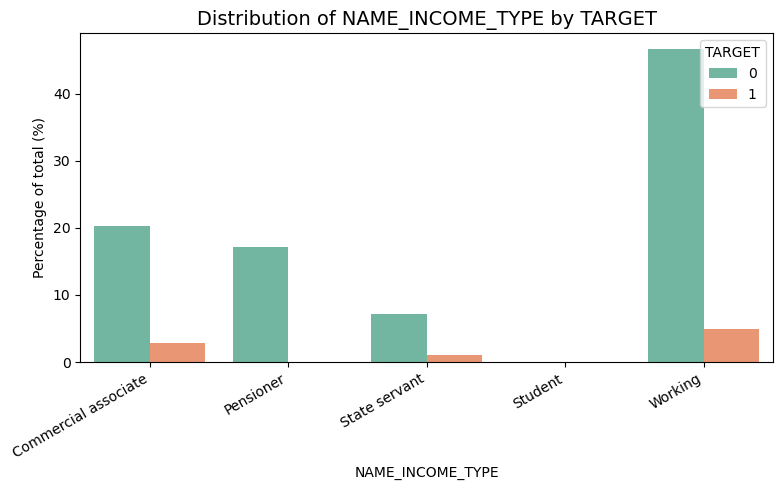

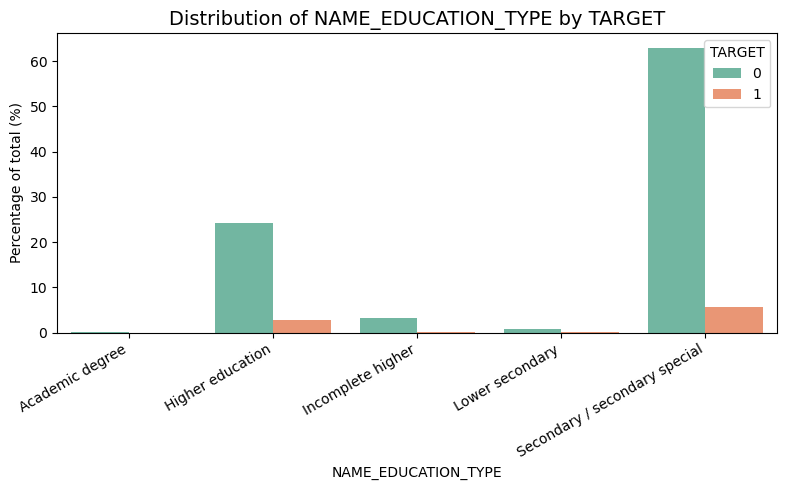

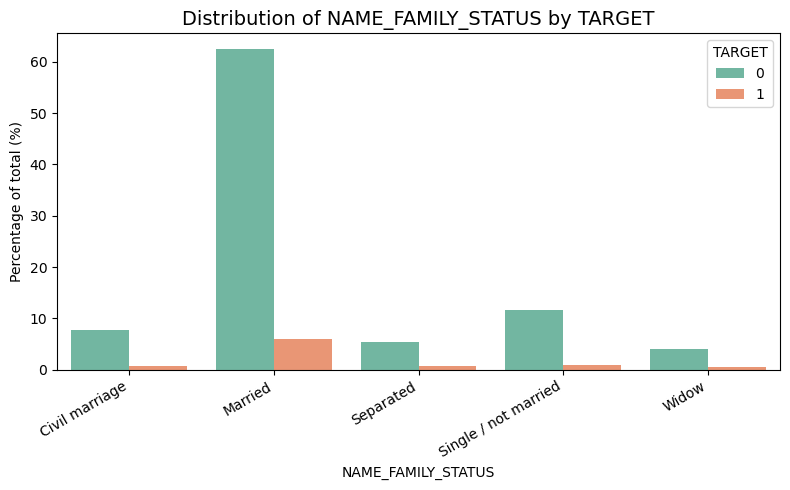

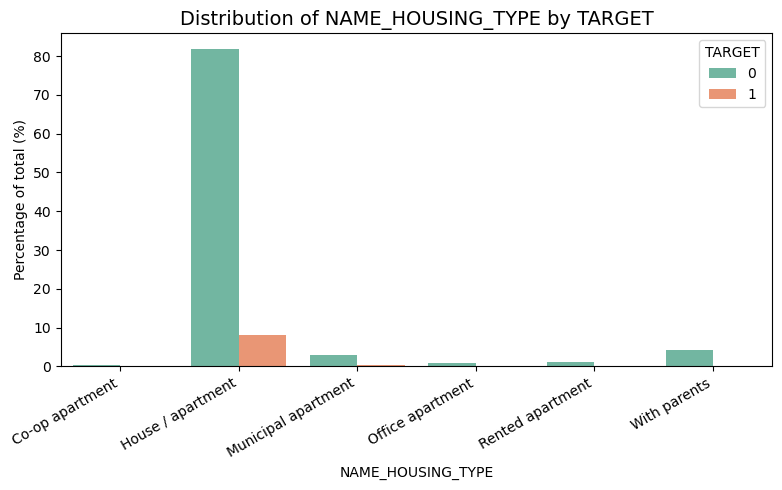

In [243]:
for feature in categorical_features[:-1]:
    #We calculate the percentages for every class by target
    df_pct = (
        data.groupby(["TARGET", feature])
        .size()
        .div(len(data))  
        .mul(100)
        .reset_index(name="percentage")
    )

    # Graphic creation
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=df_pct,
        x=feature,
        y="percentage",
        hue="TARGET",
        palette="Set2"
    )

    plt.title(f"Distribution of {feature} by TARGET", fontsize=14)
    plt.ylabel("Percentage of total (%)")
    plt.xlabel(feature)
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="TARGET", loc="upper right")
    plt.tight_layout()
    plt.show()


Clients who own a house, have a job and have a higher level of education show a significantly higher acceptance rate. This suggests that economic stability and educational background are key factors influencing the likelihood of accepting the offer.

In [244]:
# Statistic for rejection function 
# Calculate statistics from accepted clients for later comparison (before starting scaling)
statistics_original = data[data["TARGET"] == 1][['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 
                                                   'DAYS_BIRTH', 'DAYS_EMPLOYED', 
                                                   'CNT_FAM_MEMBERS']].median()

### Features Encoding

Before starting with the encoding we should split the dataset in train and test, to avoid data leakage.

In [245]:
X = data.drop(["TARGET"],axis=1)
y = data["TARGET"]
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = RANDOM_SEED,stratify=y)
X_train.shape

(236898, 13)

In [246]:
X_train = pd.get_dummies(X_train,columns=["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"],drop_first=True)
X_train = pd.get_dummies(X_train,columns=["OCCUPATION_TYPE","NAME_HOUSING_TYPE","NAME_FAMILY_STATUS","NAME_INCOME_TYPE"],drop_first=False)
Education_type_mapping = {"Lower secondary":0,"Secondary / secondary special":1,"Incomplete higher":2,"Higher education":3,"Academic degree":4}
X_train["NAME_EDUCATION_TYPE"] = X_train["NAME_EDUCATION_TYPE"].map(Education_type_mapping)

X_test = pd.get_dummies(X_test,columns=["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY"],drop_first=True)
X_test = pd.get_dummies(X_test,columns=["OCCUPATION_TYPE","NAME_HOUSING_TYPE","NAME_FAMILY_STATUS","NAME_INCOME_TYPE"],drop_first=False)
X_test["NAME_EDUCATION_TYPE"] = X_test["NAME_EDUCATION_TYPE"].map(Education_type_mapping)

In [247]:
# Some categories may appear only in the train or test split, so we reindex the test set to ensure both have the same columns.
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [248]:
#Resampling: undersample the majority so that the ratio is 70/30 %
rus = RandomUnderSampler(random_state=RANDOM_SEED,sampling_strategy=.3)
X_train,y_train = rus.fit_resample(X_train, y_train)

np.unique(y_train,return_counts=True)

(array([0, 1], dtype=int64), array([69350, 20805], dtype=int64))

In [249]:
numerical_features = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS']
ss = StandardScaler()
X_train[numerical_features] = ss.fit_transform(X_train[numerical_features])
X_test[numerical_features] = ss.transform(X_test[numerical_features])

In this phase I am applying a series of transformation to the dataset (encoding,scaling and undersampling) to prepare it for the Machine learning models

In [250]:
X_train.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,OCCUPATION_TYPE_Accountants,...,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working
218147,0.852456,-0.161809,1,1.306636,-0.395350,0.951675,True,True,True,False,...,False,True,False,False,False,False,False,False,False,True
9525,-0.560156,-0.015753,1,-1.403652,2.469758,-1.324986,False,False,True,False,...,False,False,False,True,False,False,True,False,False,False
66853,-0.560156,0.508865,3,1.404122,-0.392021,-0.186656,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
263130,-0.560156,-0.476521,1,1.053274,-0.395527,-0.186656,True,False,True,False,...,False,True,False,False,False,False,False,False,False,True
266764,-0.560156,1.200769,1,0.036359,-0.393238,-0.186656,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True


In [251]:
X_test.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,CODE_GENDER_M,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,OCCUPATION_TYPE_Accountants,...,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working
14271,-0.560156,-0.121186,3,-1.572395,-0.405445,-1.324986,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
156536,-0.560156,-0.349454,3,1.646845,-0.403148,-0.186656,True,True,False,False,...,False,True,False,False,False,True,False,False,False,False
327350,-0.560156,-0.141462,1,0.533187,-0.411432,-0.186656,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
154823,-0.560156,-0.965975,1,-1.229217,2.406955,-0.186656,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False
92065,-0.560156,-0.599914,1,-0.806369,2.368363,-0.186656,False,False,True,False,...,False,True,False,False,False,False,True,False,False,False


## Model Creation
In this phase we compare several models (LogisticRegression, KNN, SVM and Decision Tree) and the best model is chosen based on the perfomances on the test set. We will analyze different scores (precision,recall,accuracy, F1 score) and ROC - AUC. Given that the dataset is unbalanced, the accuracy will not give us a proper indication of the perfomances, since it will be over/under estimate them, for example if we the model predicts everything as the majority class it will get a good accuracy but in fact it won't get any correct prediction about the minority class.
Considering the business environment the goal is to maximize precision, to avoid accepting people that might later not pay back. Also we need to have a good recall score to avoid losing too many potential clients. 
The best model will be chosen based on ROC - AUC Score and then the model will be further optimized based on the decison threshold.

### Logistic Regression

C:\Users\GiulioZerilli\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train set Evaluation
Accuracy: 0.8321

              precision    recall  f1-score   support

           0       0.96      0.82      0.88     69350
           1       0.59      0.89      0.71     20805

    accuracy                           0.83     90155
   macro avg       0.78      0.85      0.80     90155
weighted avg       0.87      0.83      0.84     90155



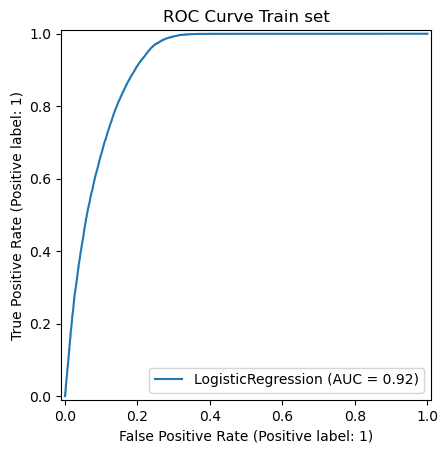

Test Set Evaluation
Accuracy: 0.8238

              precision    recall  f1-score   support

           0       0.99      0.82      0.89     92611
           1       0.32      0.89      0.47      8917

    accuracy                           0.82    101528
   macro avg       0.65      0.86      0.68    101528
weighted avg       0.93      0.82      0.86    101528



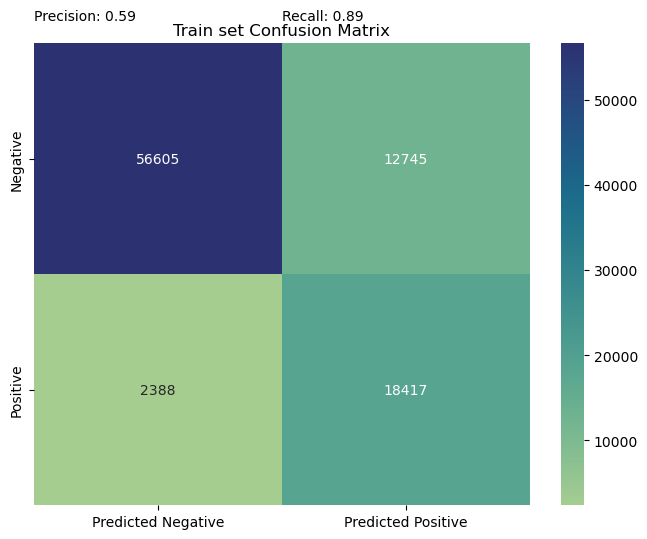

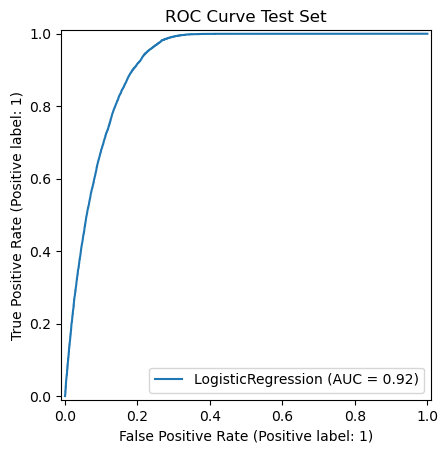

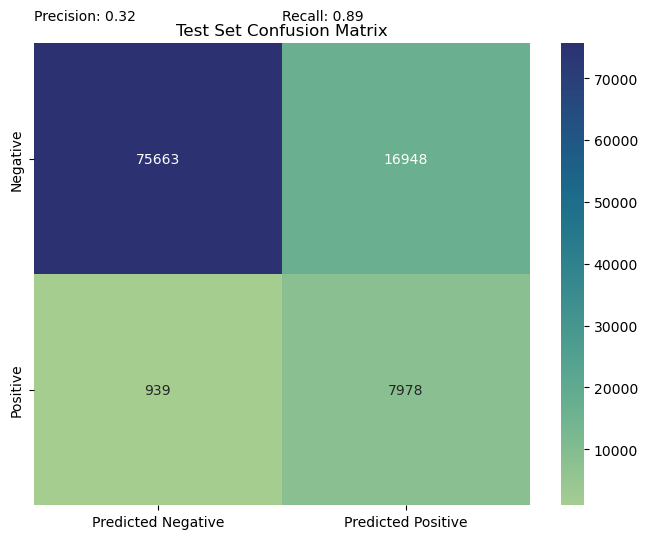

In [252]:
# We start with the Logistic Regression,Using class_weight="balanced" to compensate for class imbalance
lr = LogisticRegression(class_weight="balanced")
lr.fit(X_train,y_train)
report_result(lr,X_train,y_train)
report_result(lr,X_test,y_test,graph_title="Test Set")

#### Logistic Regression Results
Logistic Regression obtained a ROC - AUC score of 0.92 both on the train set and test set.
Accuracy between train and test set stays stable (0.83-0.82 respectively). 
F1 score drops from 0.71 to 0.47, highlighting a possible over fitting of the model; also Precision drops from train to test set, from 0.59 to 0.32. 
Instead recall stays stable.

### KNN 

In [253]:
# We try to optimize the number of k-neighbours, selecting K based on the log-loss
Ks =[5,10,15,20]

for K in Ks:
    
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train,y_train)
    
    y_pred_train=knn.predict(X_train)
    y_proba_train=knn.predict_proba(X_train)
    y_pred_test=knn.predict(X_test)
    y_proba_test=knn.predict_proba(X_test)

    f1score_train = f1_score(y_train,y_pred_train)
    f1score_test = f1_score(y_test,y_pred_test)

    log_train = log_loss(y_train,y_proba_train)
    log_test = log_loss(y_test,y_proba_test)

    print(f"k={K}")
    print( f"F1_score train: {f1score_train:.3f},F1_score Test: {f1score_test:.3f}" ) 
    print(f"LogLoss Train: {log_train:.3f}, Test:{log_test:.3f}")
    

k=5
F1_score train: 0.874,F1_score Test: 0.636
LogLoss Train: 0.131, Test:0.796
k=10
F1_score train: 0.821,F1_score Test: 0.607
LogLoss Train: 0.185, Test:0.373
k=15
F1_score train: 0.801,F1_score Test: 0.589
LogLoss Train: 0.210, Test:0.254
k=20
F1_score train: 0.780,F1_score Test: 0.581
LogLoss Train: 0.225, Test:0.225


Train set Evaluation
Accuracy: 0.9380

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     69350
           1       0.82      0.93      0.87     20805

    accuracy                           0.94     90155
   macro avg       0.90      0.94      0.92     90155
weighted avg       0.94      0.94      0.94     90155



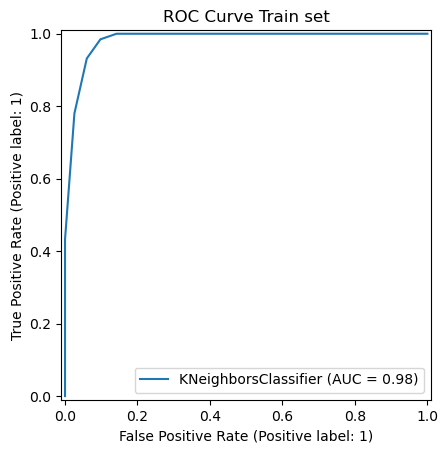

Test Set Evaluation
Accuracy: 0.9131

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     92611
           1       0.50      0.86      0.64      8917

    accuracy                           0.91    101528
   macro avg       0.74      0.89      0.79    101528
weighted avg       0.94      0.91      0.92    101528



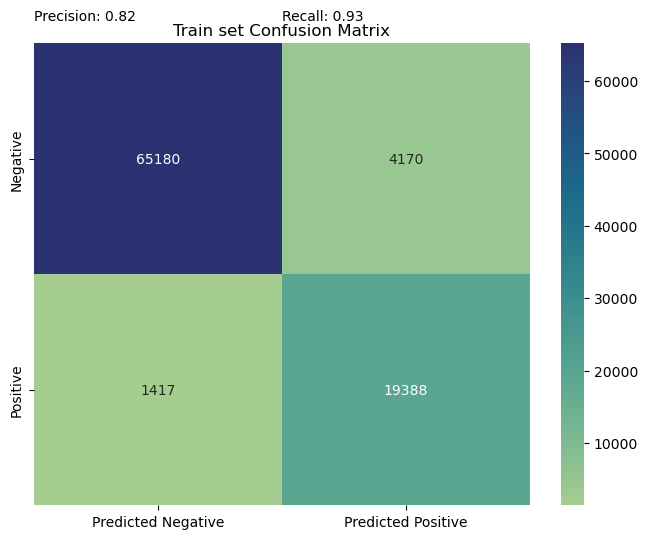

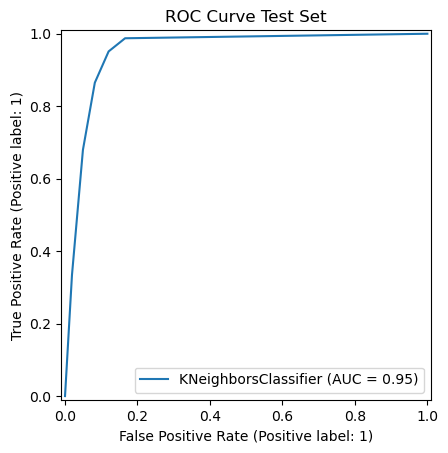

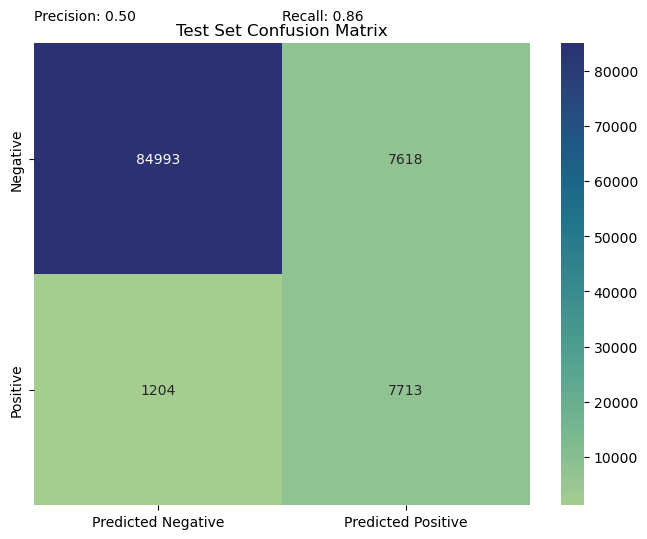

In [254]:
# We chose K based on previous results
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
report_result(knn,X_train,y_train)
report_result(knn,X_test,y_test,graph_title="Test Set")


#### KNN Results
KNN obtained a ROC - AUC score of 0.98 on the train set and 0.95 on the test set.
Accuracy between train and test set stays quite stable (0.94-0.91 respectively). 
F1 score drops from 0.87 to 0.64, highlighting a possible over fitting of the model; also Precision drops from train to test set, from 0.82 to 0.50, 
Instead recall drops from 0.93 to 0.86.
Overall this model performs better than logistic regression.

### SVM

Train set Evaluation
Accuracy: 0.8815

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     69350
           1       0.66      0.99      0.79     20805

    accuracy                           0.88     90155
   macro avg       0.83      0.92      0.86     90155
weighted avg       0.92      0.88      0.89     90155



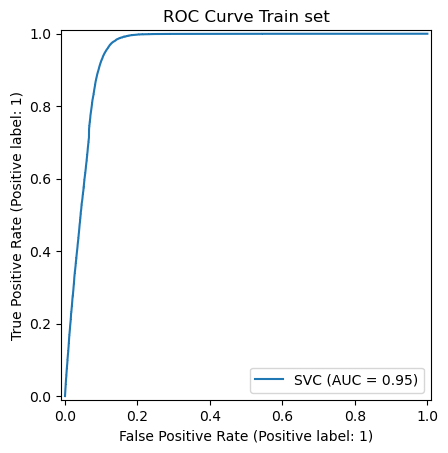

Test set Evaluation
Accuracy: 0.8585

              precision    recall  f1-score   support

           0       1.00      0.85      0.92     92611
           1       0.38      0.98      0.55      8917

    accuracy                           0.86    101528
   macro avg       0.69      0.91      0.73    101528
weighted avg       0.94      0.86      0.88    101528



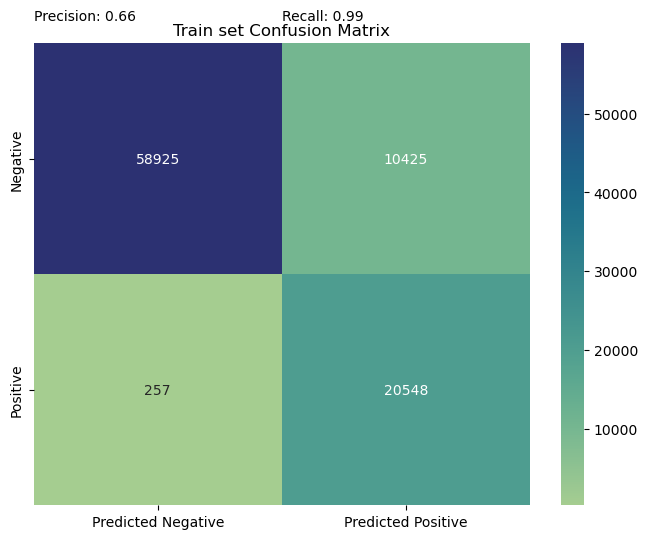

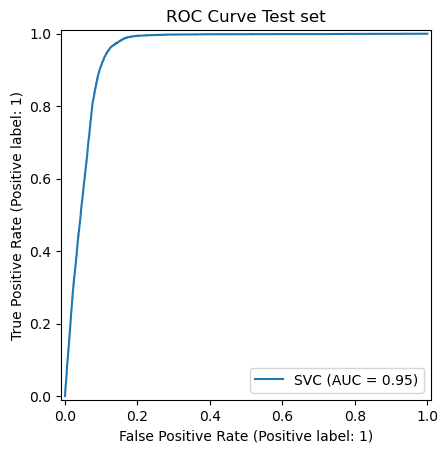

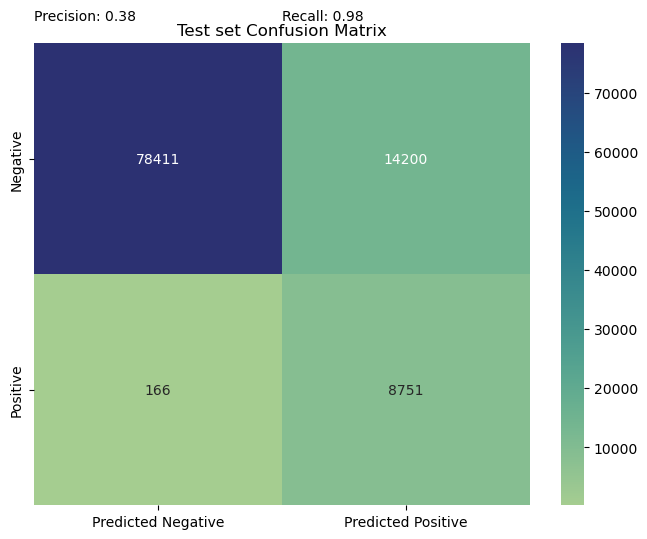

In [255]:
svc = SVC(kernel="poly", probability=True,class_weight="balanced")
svc.fit(X_train,y_train)
report_result(svc,X_train,y_train)
report_result(svc,X_test,y_test,graph_title="Test set")

Train set Evaluation
Accuracy: 0.8896

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     69350
           1       0.68      0.99      0.81     20805

    accuracy                           0.89     90155
   macro avg       0.84      0.93      0.86     90155
weighted avg       0.92      0.89      0.90     90155



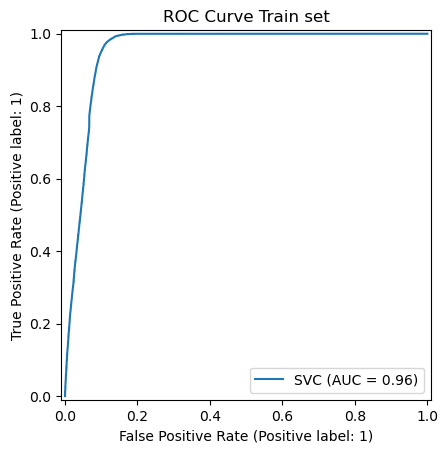

Test set Evaluation
Accuracy: 0.8676

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     92611
           1       0.40      0.99      0.57      8917

    accuracy                           0.87    101528
   macro avg       0.70      0.92      0.74    101528
weighted avg       0.95      0.87      0.89    101528



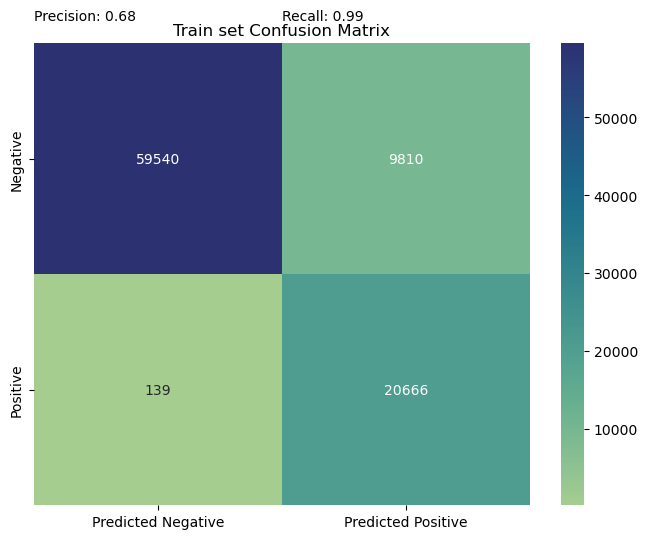

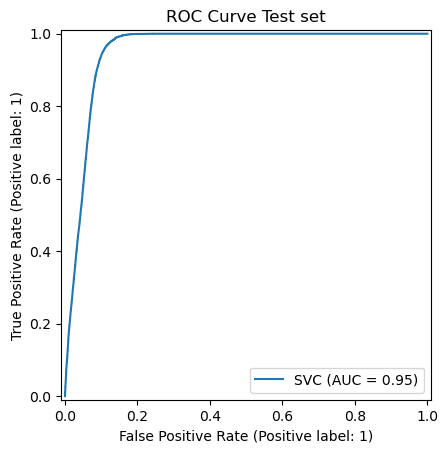

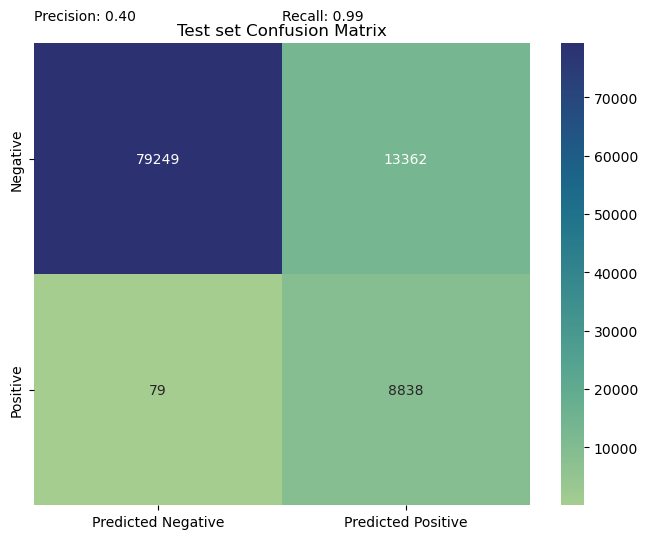

In [256]:
svc = SVC(kernel="rbf", probability=True,class_weight="balanced")
svc.fit(X_train,y_train)
report_result(svc,X_train,y_train)
report_result(svc,X_test,y_test,graph_title="Test set")

Between the two SVC models the one with "rbf" kernel performs better. 
It obtained a ROC - AUC score of 0.96 on the train set and 0.95 on the test set.
Accuracy between train and test set stays stable (0.89-0.87 respectively). 
F1 score drops from 0.81 to 0.57, highlighting a possible over fitting of the model; also Precision drops from train to test set, from 0.68 to 0.40, 
Instead recall stays stable at 0.99.
Although this model shows an excellent recall, the general performances are worse than KNN.

### DECISION TREE

In [257]:
dtc = DecisionTreeClassifier(
    criterion = "entropy",
    max_depth=15,
    min_samples_split=40,
    min_samples_leaf=20,
    random_state = RANDOM_SEED,
    class_weight="balanced"
)


In [258]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, min_samples_leaf=20, min_samples_split=40,
                       random_state=0)

Train set Evaluation
Accuracy: 0.9557

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     69350
           1       0.84      1.00      0.91     20805

    accuracy                           0.96     90155
   macro avg       0.92      0.97      0.94     90155
weighted avg       0.96      0.96      0.96     90155



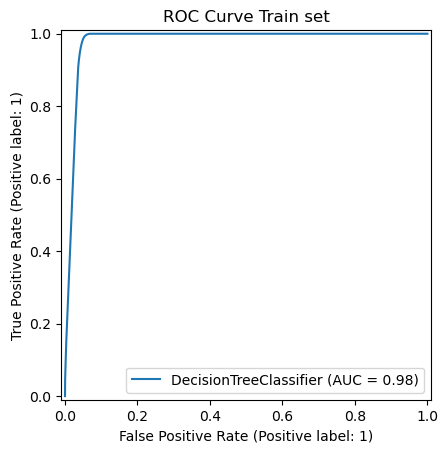

Test set Evaluation
Accuracy: 0.9476

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     92611
           1       0.63      0.99      0.77      8917

    accuracy                           0.95    101528
   macro avg       0.81      0.97      0.87    101528
weighted avg       0.97      0.95      0.95    101528



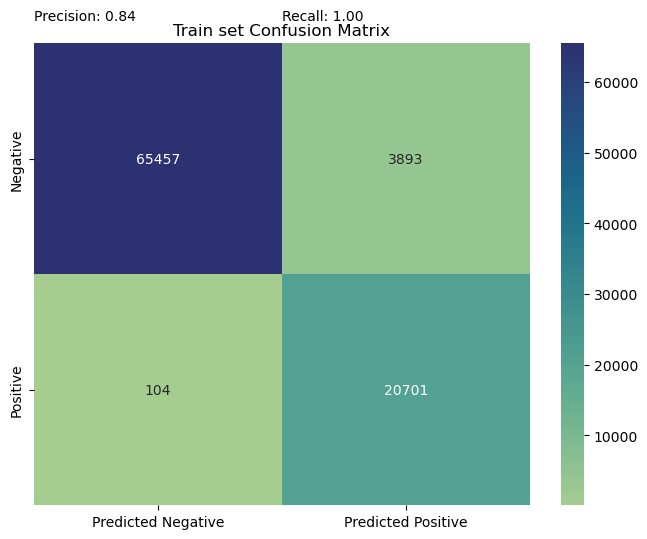

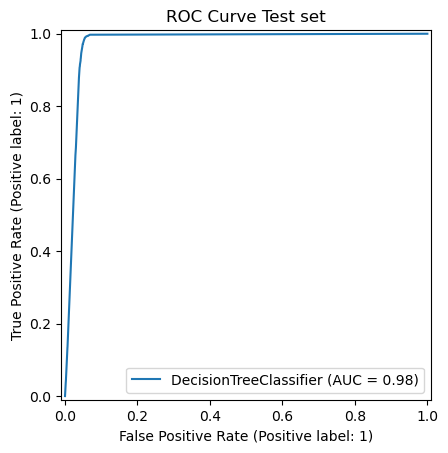

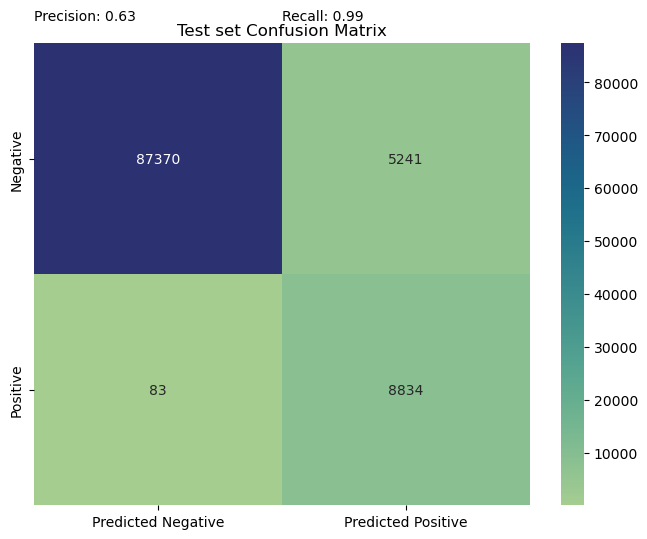

In [259]:
report_result(dtc,X_train,y_train)
report_result(dtc,X_test,y_test,graph_title="Test set")

### RANDOM FOREST

Train set Evaluation
Accuracy: 0.9551

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     69350
           1       0.84      0.99      0.91     20805

    accuracy                           0.96     90155
   macro avg       0.92      0.97      0.94     90155
weighted avg       0.96      0.96      0.96     90155



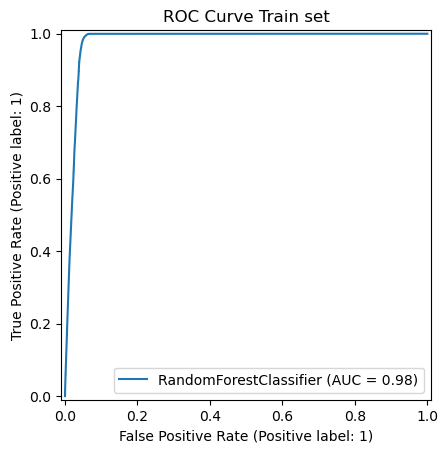

Test set Evaluation
Accuracy: 0.9476

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     92611
           1       0.63      0.99      0.77      8917

    accuracy                           0.95    101528
   macro avg       0.81      0.97      0.87    101528
weighted avg       0.97      0.95      0.95    101528



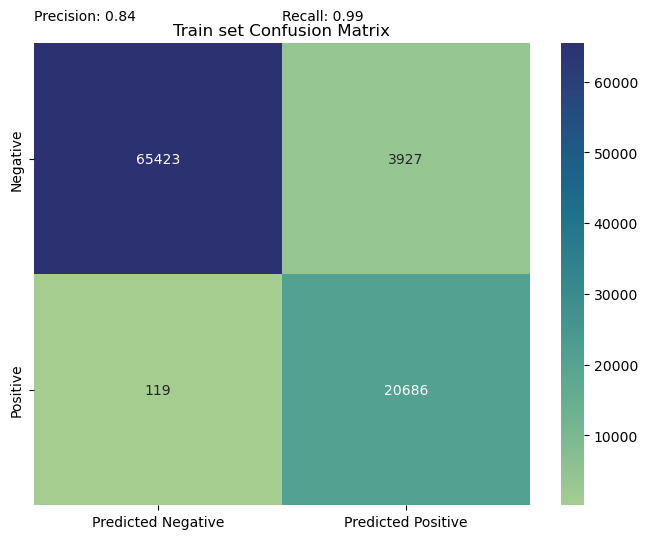

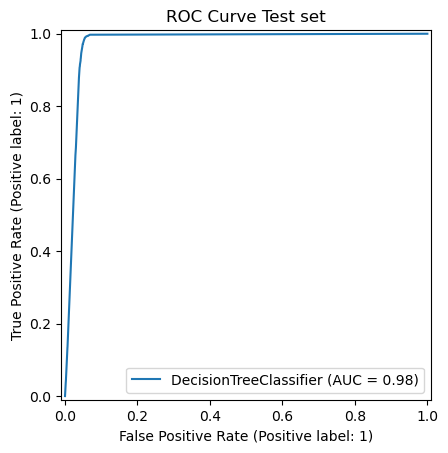

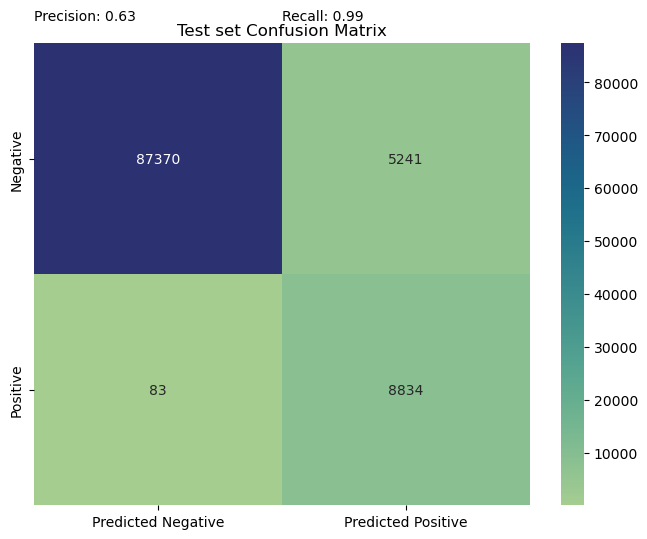

In [301]:
rfc = RandomForestClassifier(n_estimators = 50,max_features=0.8, criterion = "entropy", max_depth=10,min_samples_split=40,min_samples_leaf=20,
                             random_state=RANDOM_SEED,class_weight="balanced")
rfc.fit(X_train,y_train)
report_result(rfc,X_train,y_train)
report_result(dtc,X_test,y_test,graph_title="Test set")


Both models show similar performances, since the decision tree requires less computational power it is chosen as the best model. 
To improve the precision the decision threshold will be set at an higher value, to reduce the count of false positives.

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     92611
           1       0.69      0.91      0.78      8917

    accuracy                           0.96    101528
   macro avg       0.84      0.93      0.88    101528
weighted avg       0.96      0.96      0.96    101528



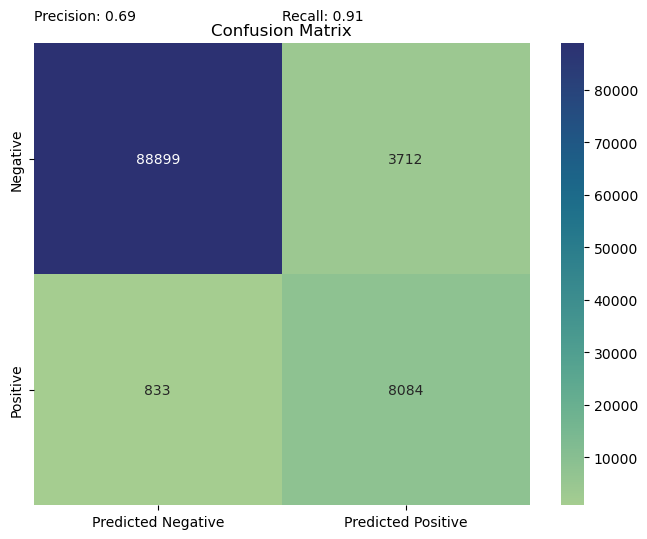

In [307]:
y_scores = dtc.predict_proba(X_test)[:,1]

threshold = 0.92
y_pred_adjusted = (y_scores > threshold).astype(int)

print(classification_report(y_test, y_pred_adjusted))
plot_cm(y_test,y_pred_adjusted,title="Confusion Matrix",show_precision_recall = True)

## Final considerations

## Rejection explanation

In [308]:
statistics = X_train[y_train==1].median()

In [309]:
feature_importance_coeff = dtc.feature_importances_
idx_top3 = (-feature_importance_coeff).argsort()[:3]
idx_top3

array([1, 3, 4], dtype=int64)

In [321]:
def client_rejection(model, client_features, statistics_original, top_features, class_names, numerical_features, scaler=None):
    """
    Gives a simple explanation of why a customer is accepted or rejected.
    Compares the client's main features against the median of accepted clients.
    """
    # Copy input
    client_copy = client_features.copy()

    # Convert Series → DataFrame
    if isinstance(client_copy, pd.Series):
        client_copy = client_copy.to_frame().T

    # Invert feature scaling (if needed)
    if scaler is not None:
        client_copy[numerical_features] = scaler.inverse_transform(client_copy[numerical_features])

    # Prediction using custom threshold
    proba = model.predict_proba(client_features)[0][1]   # probability of class 1 (Accept)
    threshold = 0.92
    prediction = int(proba > threshold)
    decision = class_names[prediction]

    # Header
    result = f"Model outcome: {decision} (probability={proba:.2f})\n"
    result += "Based on top 3 features:\n"

    # Top contributing features
    for feature in top_features:
        value = client_copy.iloc[0][feature]
        median_val = statistics_original[feature]

        direction = "higher" if value > median_val else "lower"
        diff = abs(value - median_val)

        result += f" - {feature}: {value:.2f} ({direction} than median {median_val:.2f}, Δ={diff:.2f})\n"

    # Final explanation
    if prediction == 0:
        result += "\nThe client was REJECTED based on these feature values."
    else:
        result += "\nThe client was ACCEPTED based on these feature values."

    print(result)


In [323]:
client_rejection (dtc,X_test.iloc[[0]], statistics_original, X_test.columns[idx_top3],["Reject","Accept"],numerical_features,scaler=ss)

Model outcome: Accept (probability=0.97)
Based on top 3 features:
 - AMT_INCOME_TOTAL: 186245.30 (lower than median 228884.48, Δ=42639.18)
 - DAYS_BIRTH: -22746.00 (lower than median -18238.50, Δ=4507.50)
 - DAYS_EMPLOYED: -2177.00 (higher than median -3746.00, Δ=1569.00)

The client was ACCEPTED based on these feature values.
